# Dalhi Daily Climate Time Series Project
### Timeseries projects using the statistical approach

Author: Geovanna Santos Nobre de Oliveira

The dataset:

**Link:** [Daily Climate Time Series Data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download)

**Content:** The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure.

**Acknowledgements:** This dataset has been collected from Weather Undergroud API. Dataset ownership and credit goes to them.

## 1. Statistical Approach: SARIMA

### 1.1. Importing libraries and loading data

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import sqrt

from itertools import product

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [3]:
plt.rcParams['figure.figsize'] = [20, 10]


In [4]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv',
                       header=0, index_col=0, parse_dates=True, squeeze=True)
df_test = pd.read_csv('DailyDelhiClimateTest.csv', header=0,
                      index_col=0, parse_dates=True, squeeze=True)

df_train = df_train['meantemp']
df_test = df_test['meantemp']


### 1.2. Information about the data

In [5]:
df_train.head(10)


date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
2013-01-06     7.000000
2013-01-07     7.000000
2013-01-08     8.857143
2013-01-09    14.000000
2013-01-10    11.000000
Name: meantemp, dtype: float64

In [6]:
df_train.tail()


date
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, dtype: float64

In [7]:
df_train.describe()


count    1462.000000
mean       25.495521
std         7.348103
min         6.000000
25%        18.857143
50%        27.714286
75%        31.305804
max        38.714286
Name: meantemp, dtype: float64

Text(0.5, 1.0, 'Mean Temperature in Dehli')

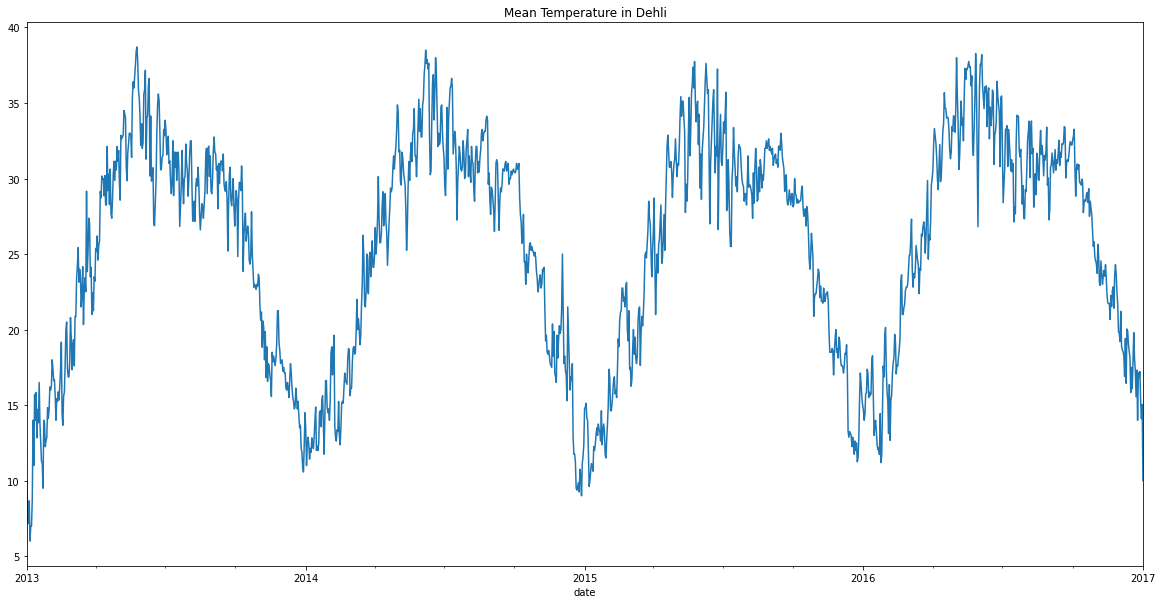

In [8]:
df_train.plot(style='-')
plt.title('Mean Temperature in Dehli')


Text(0.5, 1.0, 'Mean Temperature in Dehli - Monthly')

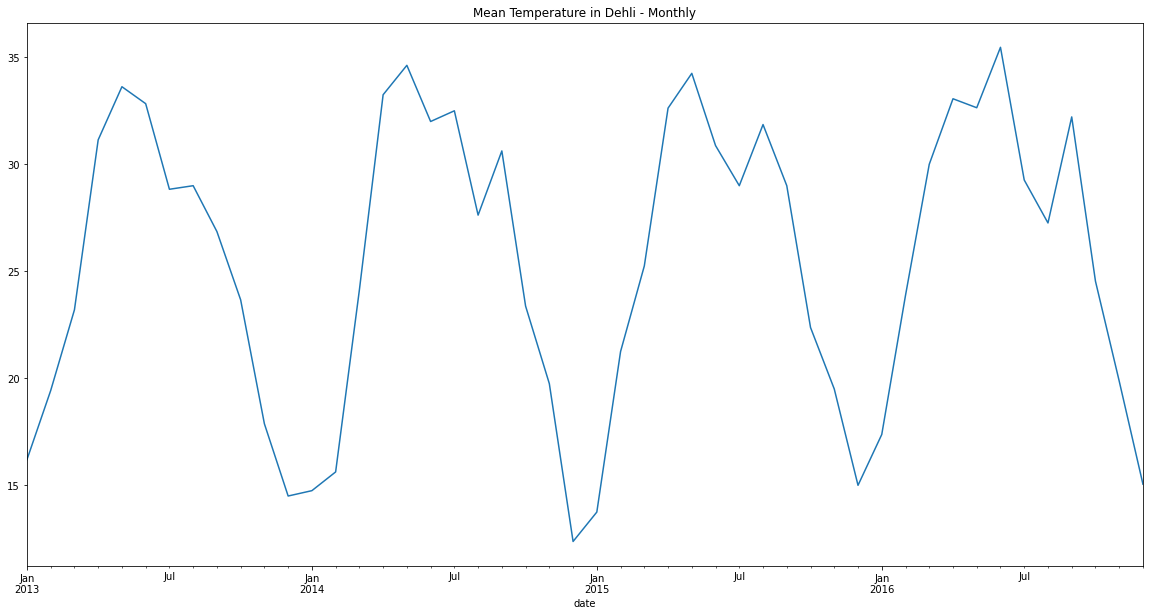

In [9]:
df_train.asfreq('M').plot()
plt.title('Mean Temperature in Dehli - Monthly')


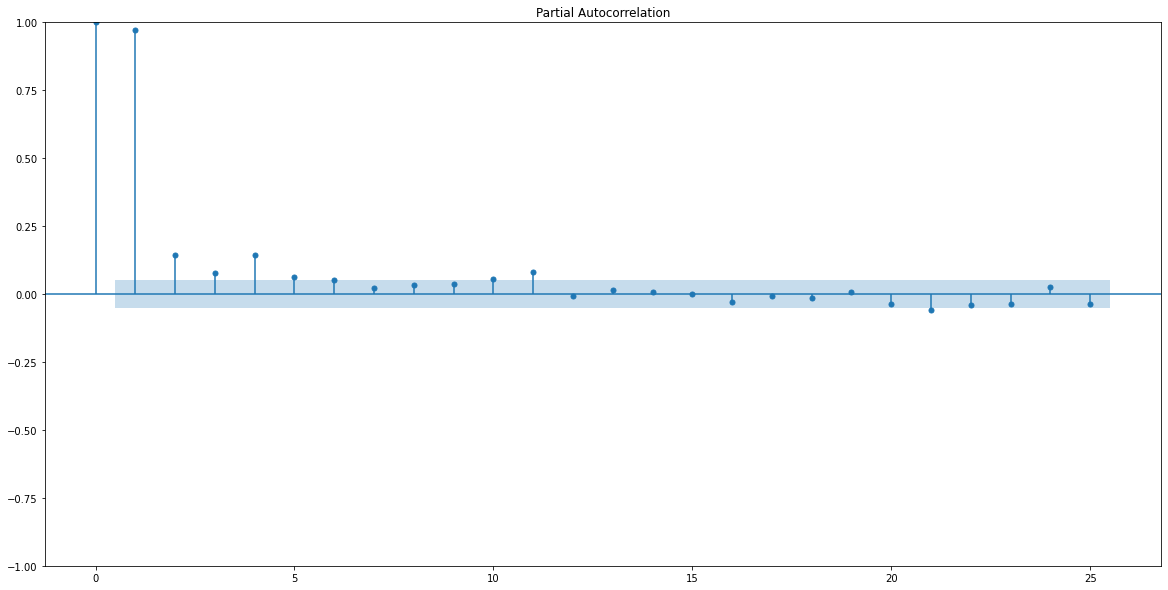

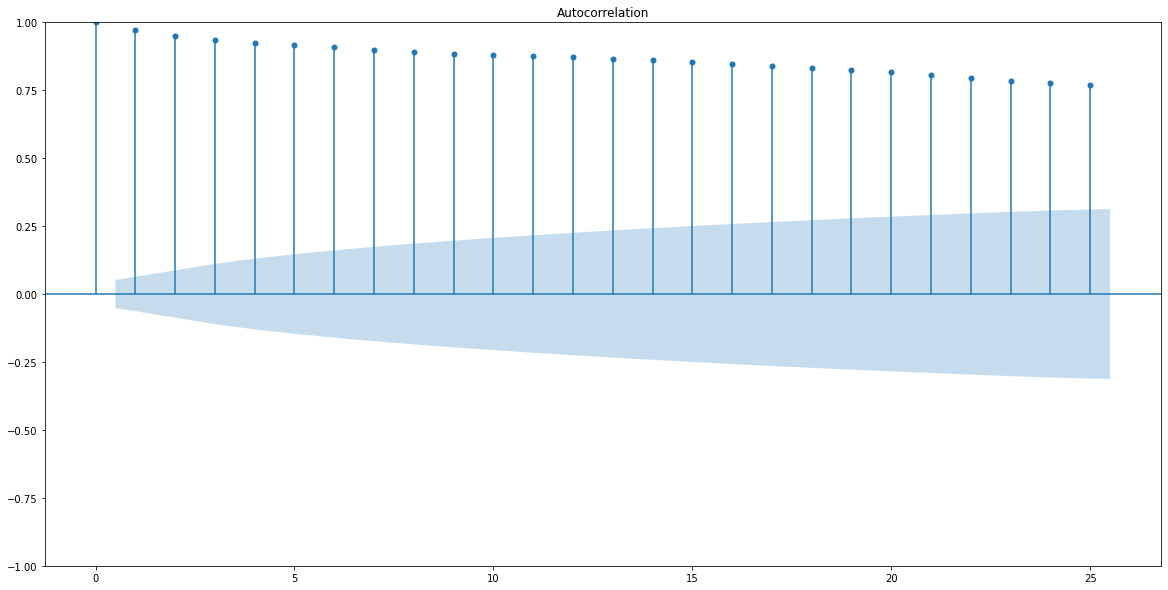

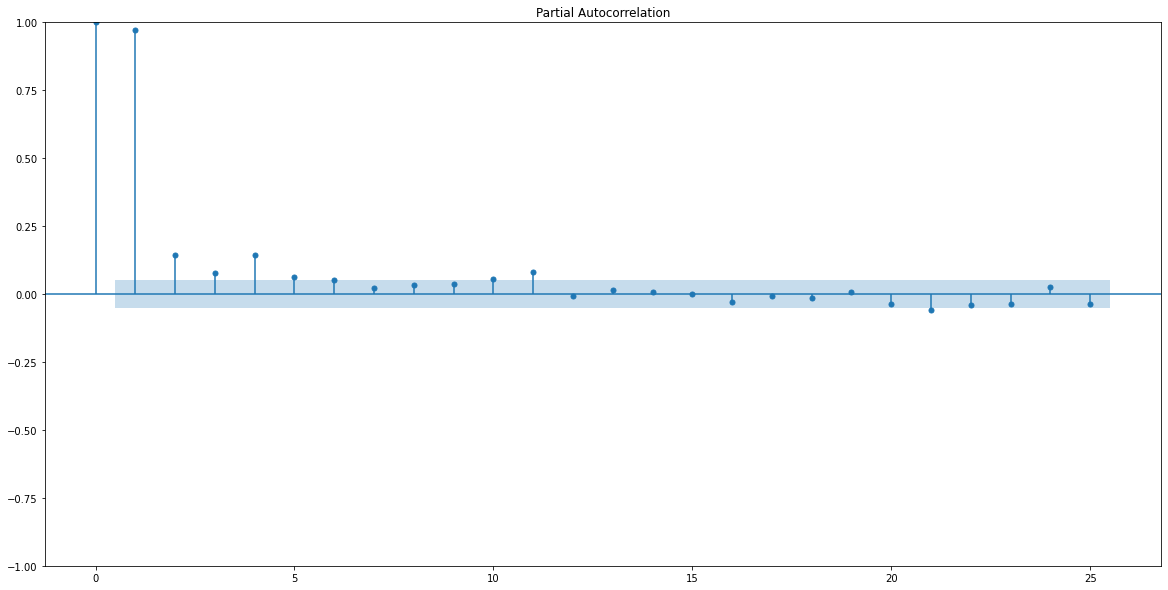

In [10]:
plot_acf(df_train, lags=25)
plot_pacf(df_train, lags=25)


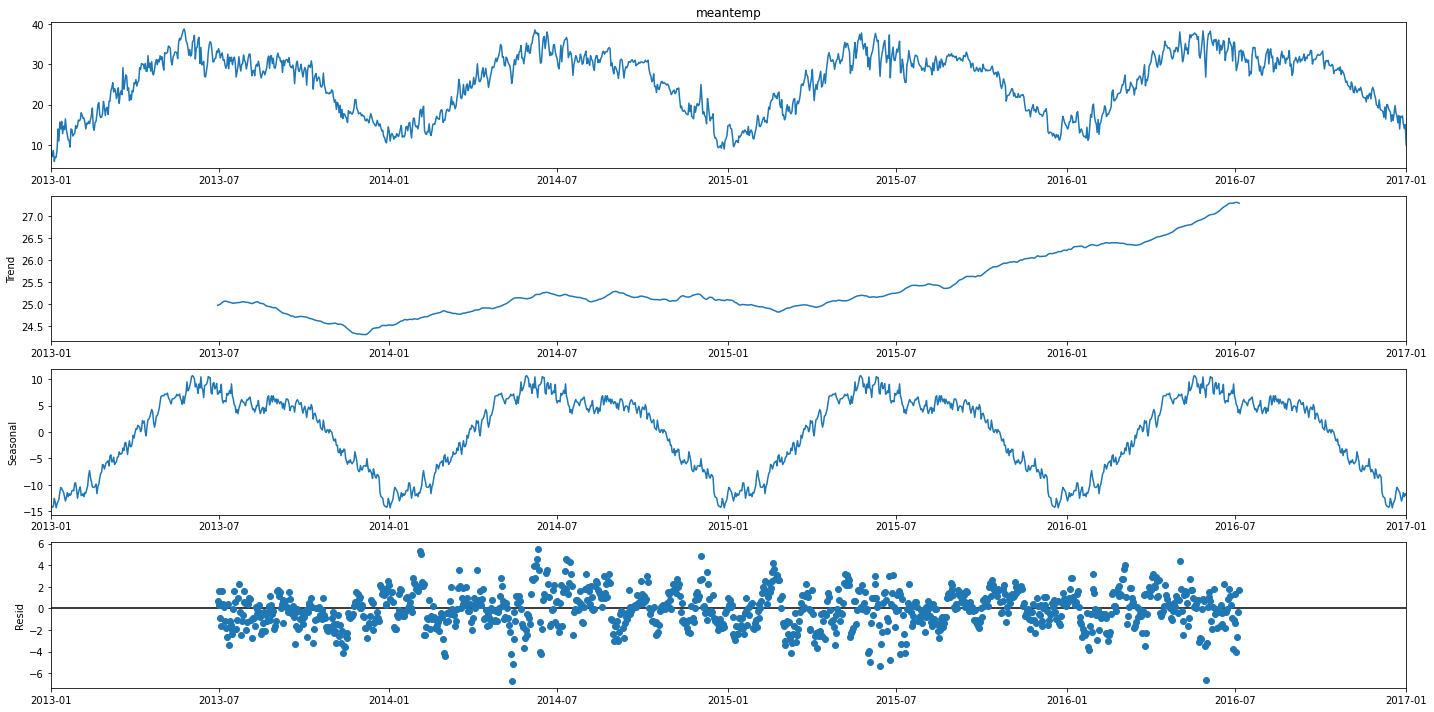

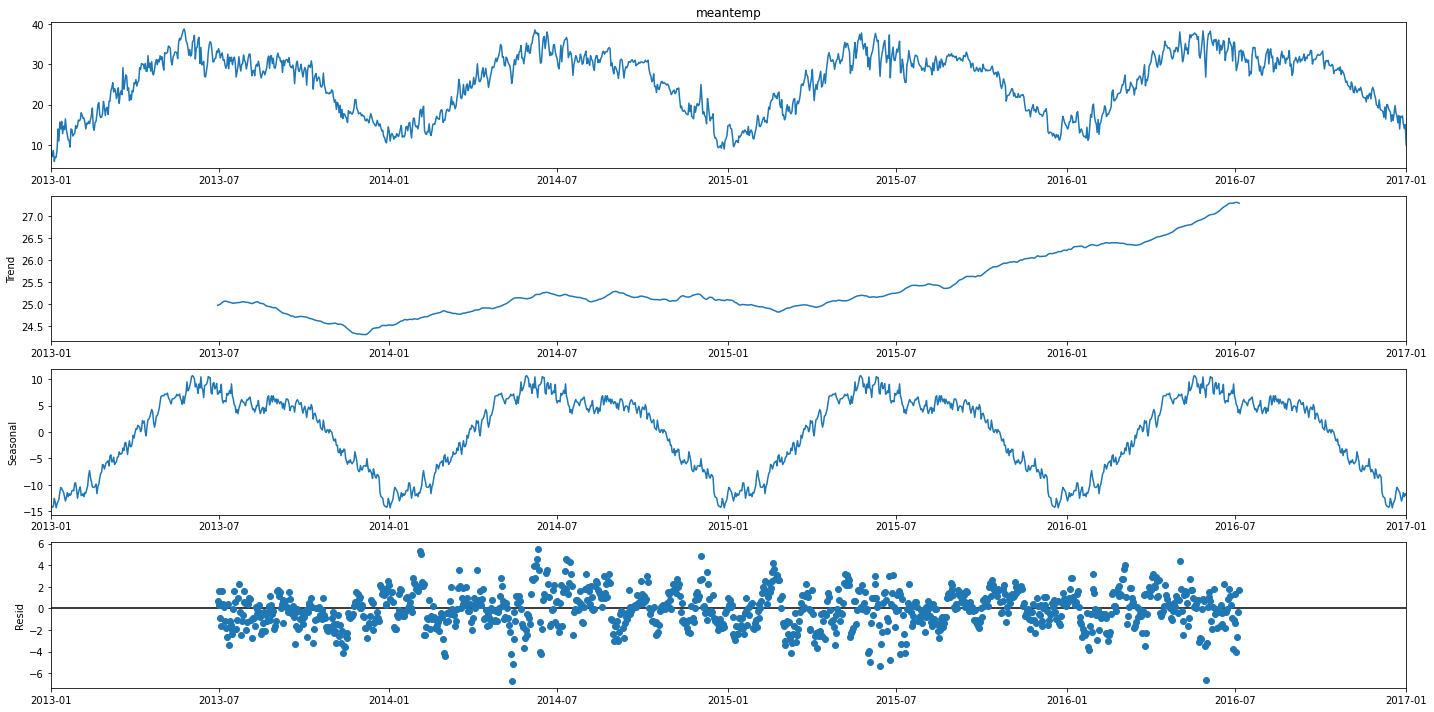

In [11]:
sm.tsa.seasonal_decompose(df_train, period=360).plot()


### 1.3. Modeling

In [12]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters and corresponding AIC

        Args:
            endog : the observed variables
            parameters_list : list with (p, q, P, Q) tuples
            d : integration order
            D : seasonol integration order
            s : length of a season
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(
                endog,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q) x (P,Q)', 'AIC']

    result_df = result_df.sort_values(
        by='AIC', ascending=True).reset_index(drop=True)

    return result_df


Deciding the parameters range

In [27]:
p = range(0, 3, 1)
d = 0
q = range(0, 3, 1)

P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)

s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(df_train.asfreq('M'), parameters_list, d, D, s)
result_df


  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q) x (P,Q)",AIC
0,"(0, 0, 0, 1)",169.675706
1,"(0, 0, 1, 0)",169.917231
2,"(0, 1, 0, 1)",170.975635
3,"(1, 0, 0, 1)",171.038822
4,"(0, 1, 1, 0)",171.165206
...,...,...
76,"(0, 2, 2, 2)",178.657843
77,"(2, 0, 2, 2)",178.830740
78,"(2, 1, 2, 2)",179.684312
79,"(2, 2, 2, 2)",179.928880


In [28]:
best_model = SARIMAX(
    df_train.asfreq('M'), 
    order=(0,0,0), 
    seasonal_order=(0,1,1,12),
    simple_differencing=False)

model_fit = best_model.fit(disp=False)


In [59]:
n_forecast = df_test.asfreq('M').shape[0]
predict = model_fit.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))


In [61]:
rmse = sqrt(mean_squared_error(df_test.asfreq('M'), predict.predicted_mean[-n_forecast:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.062


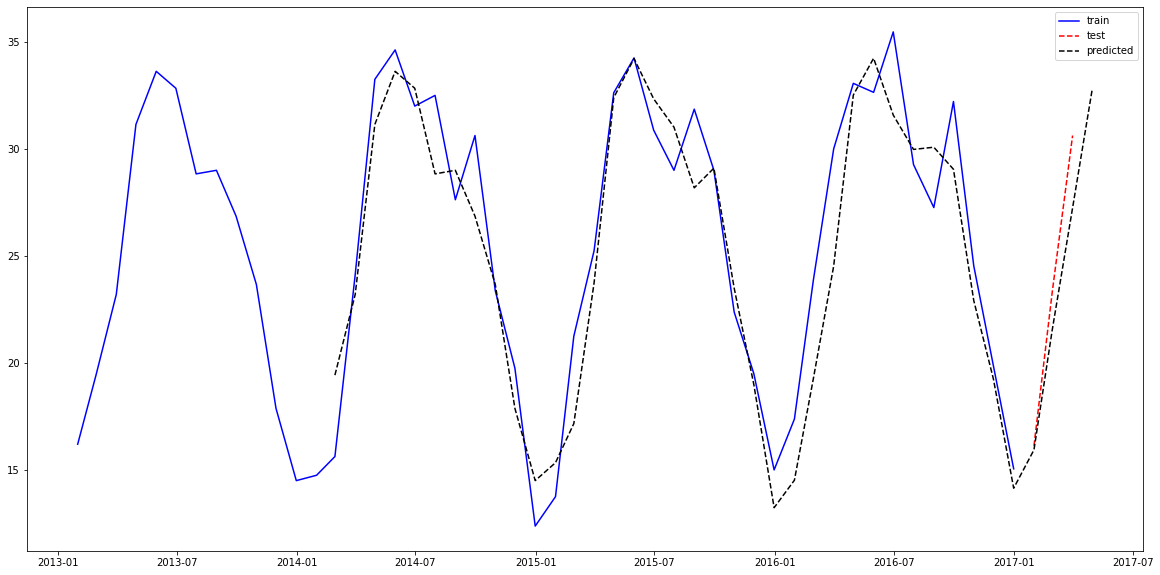

In [80]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_train.asfreq('M'), 'blue')
ax.plot(df_test.asfreq('M'), 'k--', color='red')
ax.plot(predict.predicted_mean[-13*n_forecast:], 'k--')

plt.legend(['train', 'test', 'predicted'])

Here, we predicted the temperature on a monthly basis to account for seasonality. We can see that the model takes in acount the variation in the year basis and its predictions get very close to the real values. Its RMSE is 4.062. Now let's see the predictions using Deep Learning in the nest notebook.
